This notebook provides examples for comparing re-basin with the same basin scenario. The same basin scenario is approximated by retraining.

In [1]:
import sys
sys.path.append("..")

In [14]:
import torch
from source.utils.utils import load_model
from source.utils.data_funcs import load_data
from source.utils.weight_matching import weight_matching, get_permutation_spec, apply_permutation
from source.utils.connect import eval_line
from source.utils.logger import Logger
from torch.utils.data import DataLoader
from source.utils.train import train
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
class config:
    model = 'cifar_vgg16_bn'
    dataset = 'cifar10'
    special_init = 'vgg_init' # 'vgg_init' (kaiming init) or None (uniform init)
    print_freq = 100
    data_dir = '../../Linear_Mode_Connectivity/data'
    n = 3 # number of interpolation points

In [4]:
# necessary to create logger if using the train/validate/eval_line etc. functions
Logger.setup_logging()
logger = Logger()

trainset, testset = load_data(config.data_dir, config.dataset)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

trainset_noaug, _ = load_data(config.data_dir, config.dataset, no_random_aug=True)
trainloader_noaug = DataLoader(trainset_noaug, batch_size=128, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
model_1, model_2 = load_model(config).to(device), load_model(config).to(device)

sd_1 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_10/model_1_160.pt', map_location=device)
sd_2 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_10/model_2_160.pt', map_location=device)

model_1.load_state_dict(sd_1)
model_2.load_state_dict(sd_2)

<All keys matched successfully>

In [ ]:
sd_2_wm, perm_2_wm = weight_matching(config.model, sd_1, sd_2, device=device, return_perm=True)
model_2_wm = load_model(config).to(device)
model_2_wm.load_state_dict(sd_2_wm)

Retraining

In [8]:
model_retrain = load_model(config).to(device)
model_retrain.load_state_dict(sd_2)

optimizer_retrain = torch.optim.SGD(model_retrain.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

In [ ]:
for epoch in range(20):
    train(trainloader, model_retrain, criterion, optimizer_retrain, epoch, device, config)
    
optimizer_retrain.param_groups[0]['lr'] = 0.01
for epoch in range(5):
    train(trainloader, model_retrain, criterion, optimizer_retrain, epoch, device, config)

In [ ]:
lmc_ori = eval_line(model_1, model_2, testloader, criterion, device, config, n=config.n)
lmc_wm = eval_line(model_1, model_2_wm, testloader, criterion, device, config, n=config.n)
lmc_wm_reset = eval_line(model_1, model_2_wm, testloader, criterion, device, config, n=config.n, reset_bn=True, bn_loader=trainloader)
lmc_retrain = eval_line(model_2, model_retrain, testloader, criterion, device, config, n=config.n)

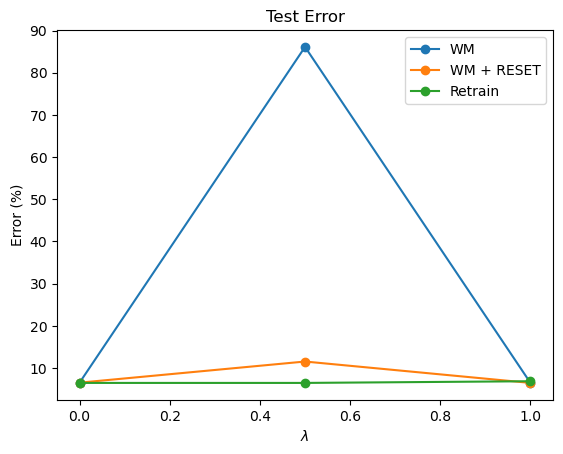

In [20]:
x_axis = np.linspace(0, 1, config.n)

plt.plot(x_axis, 100 - lmc_wm[:, 1], label='WM', marker='o')
plt.plot(x_axis, 100 - lmc_wm_reset[:, 1], label='WM + RESET', marker='o')
plt.plot(x_axis, 100 - lmc_retrain[:, 1], label='Retrain', marker='o')

plt.title('Test Error')
plt.xlabel(r'$\lambda$')
plt.ylabel('Error (%)')
plt.legend()

Apply random permutation to the basin

In [15]:
random_perm = deepcopy(perm_2_wm)
for k, v in random_perm.items():
    random_perm[k] = torch.randperm(v.shape[0]).to(device)
ps = get_permutation_spec(config.model)
sd_retrain_randperm = apply_permutation(ps, random_perm, model_retrain.state_dict(), device)
model_retrain_randperm = load_model(config).to(device)
model_retrain_randperm.load_state_dict(sd_retrain_randperm)

<All keys matched successfully>

In [ ]:
sd_retrain_randperm_wm, random_perm_inverse = weight_matching(config.model, sd_2, sd_retrain_randperm, device=device, return_perm=True)
model_retrain_randperm_wm = load_model(config).to(device)
model_retrain_randperm_wm.load_state_dict(sd_retrain_randperm_wm)

In [18]:
from sympy.combinatorics import Permutation
different = 0
for k, v in random_perm.items():
    p_true_inverse = np.array((Permutation(v)**-1).list())
    p_inverse = np.array(Permutation(random_perm_inverse[k]).list())
    different += np.sum(p_true_inverse != p_inverse)
print(f'Number of different elements: {different}')

Number of different elements: 0


In [ ]:
lmc_retrain_perm = eval_line(model_2, model_retrain_randperm, testloader, criterion, device, config, n=config.n)
lmc_retrain_perm_wm = eval_line(model_2, model_retrain_randperm_wm, testloader, criterion, device, config, n=config.n)

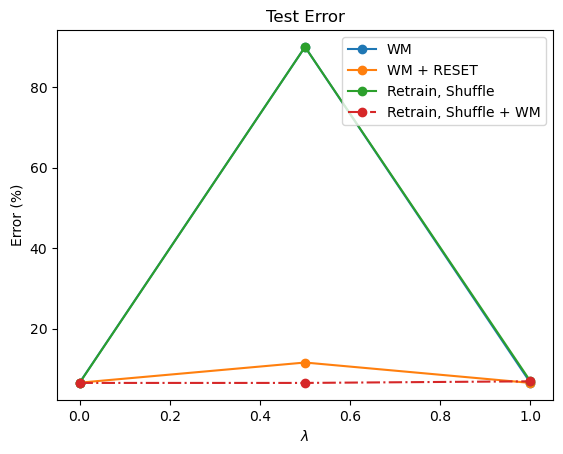

In [21]:
x_axis = np.linspace(0, 1, config.n)

plt.plot(x_axis, 100 - lmc_ori[:, 1], label='WM', marker='o')
plt.plot(x_axis, 100 - lmc_wm_reset[:, 1], label='WM + RESET', marker='o')
plt.plot(x_axis, 100 - lmc_retrain_perm[:, 1], label='Retrain, Shuffle', marker='o')
plt.plot(x_axis, 100 - lmc_retrain_perm_wm[:, 1], label='Retrain, Shuffle + WM', linestyle='-.', marker='o')

plt.title('Test Error')
plt.xlabel(r'$\lambda$')
plt.ylabel('Error (%)')
plt.legend()